#**Deep Learning Homework 2: *Optimize and Train Deep Models***
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Deep Neural Network for a classification problem. We will learn how to use one of the most popular libraries for Deep Learning, namely [PyTorch 🔥](https://pytorch.org/). Then, we will see how to face a well known problem that is common during the training phase---overfitting on the training set. Finally, we will study how to perform a fair model selection. 

<u>Disclaimer</u>: PyTorch is a complex framework actively used by researcher and developers all over the word. It is highly customizable and there are many other packages build along it. The pourpouse of this and the next homeworks is not to go into all the details of its functionalities, but rather to give you an overview of its applications and understand its rationale. There are many good tutorials online and we suggest you to look at the official [Learn the Basics Tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html), in particular if you are not familiar with other Deep Learning Frameworks. 

We hope that you will be able to use PyTorch by yourself for your future projects! 
---
##**Important Instructions for Submissions:**

Generally, in the homeworks, you will be either required to complete a part of Python code or to answer questions in text cells. Code and text cells where you are expected to write your answers have been marked by `%STARTCODE` and `%ENDCODE` or `%STARTEXT` and `%ENDTEXT` tags, respectively. Note that you should never change, move or remove these two tags, otherwise your answers will be __not__ valid. As you will see in this notebook, each cell that includes a `[TO COMPLETE]` part has been put between these placeholders. 

## Requirements

In this first exercise we will develop a deep feed forward neural network to perform text classification.

Let's start importing the libraries we will need and setting a couple of environmental variables.

In [1]:
# They've just released torch 2.0, but we will use the more stable torch=1.13 along with other supporting libriaries
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext==0.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━

##Imports

In [2]:
import torch
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier 
from skorch.helper import SliceDataset
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import os
from timeit import default_timer as timer

In [3]:
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.0+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 525.85.12, 15360 MiB, 3 MiB, 15098 MiB


#Data Loading and Preprocessing

### Load Data: AG News Subset

In this HW, we use the AG News Subset that is available in Torchtext Datasets. The AG's news topic classification dataset is constructed by choosing the 4 largest topic classes (1-World, 2-Sports, 3-Business, 4-Sci/Tech) from a larger news corpus. The total number of training samples is $120.000$ and testing $7.600$. For resource constraints, we will limit the number of training, validation and test samples to $10.000$, $1.000$ and $1.000$, respectively. Each sample contains both the title and an excerpt of the article, but in this exercise we will use only the excerpt as input.

In [4]:
train, test = AG_NEWS(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 10000, 1000, 1000
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

And have a look at one sample:

In [5]:
idx = 10
sample_label, sample_text = train_data[idx]
print(f"Text: {sample_text}")
print(f"Label: {sample_label}")

Text: Vancouver man is victim of shoddy FBI investigation: lawyer (Canadian Press) Canadian Press - VANCOUVER (CP) - A Vancouver man wanted by the U.S. for the 30-year-old murder of an American Indian Movement activist is being persecuted based on a faulty FBI investigation and the word of a troubled drug addict, says the lawyer defending his so-called partner in crime.
Label: 1


### Data Preprocessing
We will go though the basic data processing building blocks for raw text string.
Given a string, the first step is to tokenize the data to prepare it as input for the model. For this purpouse, we will use the basic Tokenizer of PyTorch. As you can see, it just normalizes the text, removes whitespaces and unsupported characters, and outputs a list:

In [6]:
tokenizer = get_tokenizer('basic_english')
print("Example: ", tokenizer("I am so HAPPY to study Deep Learning! #UNIPD #UniLIFE"))

Example:  ['i', 'am', 'so', 'happy', 'to', 'study', 'deep', 'learning', '!', '#unipd', '#unilife']


The AG News Subset dataset consists in news headlines---sequences of words. We have to encode each sample in a single tensor with a fixed number of elements, we will build a vocabulary of the headlines in our training set. In other words, we tokenize all the training set, and map each unique word into a number (a.k.a. index). This is necesseray as Neural Networks process numbers, so such vocabulary simply translates between readable words and numbers.

In [7]:
def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

# We limit our model to learn from the first 1000 most frequent tokens
vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<unk>"], max_tokens=1000) # <unk> is the index we use for specials characters ...
vocab.set_default_index(vocab["<unk>"]) # ... and as 0 the default values for tokens out of the vocabulary (OOV)
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 1000 tokens-index pairs.


This vocabulary was build from the training set. Let us see what it does on our example:

In [8]:
# Let us define some useful functions to handle tokens and labels
text_pipeline = lambda x: vocab(tokenizer(x)) # function to go from string -> tokens
label_pipeline = lambda x: int(x) - 1 # function to label starting form 0 for indexing

In [9]:
sample_tokenization = text_pipeline(sample_text)
sample_label_idx = label_pipeline(sample_label)
print(f"Samlpe headline text:\n {sample_text}")
print(f"Sample headline to tokens:\n {sample_tokenization}")
print(f"Label:\n {sample_label}")
print(f"Label index:\n {sample_label_idx}")

Samlpe headline text:
 Vancouver man is victim of shoddy FBI investigation: lawyer (Canadian Press) Canadian Press - VANCOUVER (CP) - A Vancouver man wanted by the U.S. for the 30-year-old murder of an American Indian Movement activist is being persecuted based on a faulty FBI investigation and the word of a troubled drug addict, says the lawyer defending his so-called partner in crime.
Sample headline to tokens:
 [0, 415, 23, 0, 6, 0, 0, 963, 0, 13, 313, 262, 14, 313, 262, 15, 0, 13, 780, 14, 15, 5, 0, 415, 0, 24, 2, 51, 1, 9, 1, 11, 2, 0, 0, 6, 31, 159, 637, 0, 0, 23, 264, 0, 0, 10, 5, 0, 0, 963, 8, 2, 0, 6, 5, 0, 380, 0, 3, 82, 2, 0, 0, 34, 0, 0, 7, 0, 1]
Label:
 1
Label index:
 0


So each word is correctly mapped into a number, where most frequent words come first (see that the preposition "of", which is very frequent, gets translated to the number $6$). Notice also how "Vancouver" takes the default index value of $0$, meaning that is not frequent in the training set. 

Neural Netowrks (usually) take input of fixed size, but news aricles have different lenghts! To tackle this issue, one way is to resort to _multi-hot-encoding_ our dataset, means turning it into a tensor of $0$ and $1$. Concretely, this would mean for instance turning the sequence `[3, 5]` into a $1000$-dimensional vector (our vocabulary) that would be all zeros except for indices 3 and 5, which would be ones. The obtained input representation indicates which words are present (at least one time) in the sentence.

In [10]:
def multi_hot(token_list, n_cat=len(vocab)):
  encoded = [1 if i in token_list else 0 for i in range(n_cat)]
  return encoded

The next step is building a PyTorch `DataLoader`. Without going too much into the details, a `DataLoader` is the object one uses in the `for` loops when iterating over the data for training or inference. It has some additional benefits and pourpouses over iterating usual lists, such as multiprocessing, data transformation, sampling or shuffling. Don't worry too much for now, as we do this part for you. 

In [11]:
class AGNewsDataset(Dataset):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    lb = label_pipeline(label)
    txt = multi_hot(text_pipeline(text))
    lb, txt = torch.tensor(lb, dtype=torch.uint8, device=device), torch.tensor(txt, dtype=torch.float32, device=device)
    return lb, txt

In [12]:
train_dataset = AGNewsDataset(train_data)
val_dataset = AGNewsDataset(val_data)
test_dataset = AGNewsDataset(test_data)

In [13]:
batch_size = 256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Exercise 2.1: Model Definition and Training
We can now define the 3-layers feed forward model!
In PyTorch we do that by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

In detail, we created a `FeedforwardNetwork` class. The constructor takes three arguments: `input_dim` (an integer), which is the dimension of the input layer; `num_classes` (an integer), which is the number of output classes; and `hidden_layers_dim` (a list of integers), which is the dimension of the hidden layers in the network.

In the constructor, the `nn.ModuleList() ` object is initialized to hold the layers of the network. If `hidden_layers_dim` is an empty list, then the network only consists of a single linear layer (from input to output). Otherwise, the network consists of multiple linear layers. The first layer goes from the input layer to the first hidden layer, and the subsequent hidden layers go from the previous hidden layer to the next hidden layer. The final output layer goes from the last hidden layer to the output layer.

The `_init_weights` function is a helper function that initializes the weights of the linear layers in the network. It initializes the weights using a normal distribution with a mean of 0 and a standard deviation of 0.1, and sets the biases to zero. Notice that there exist other methods available in the `torch.nn.init` module to initialize layers' weights.

The `forward` function defines the forward pass of the network. It first checks whether the network has only one layer (in which case it simply returns the output of that layer). Otherwise, it applies the `relu` activation function to the output of each hidden layer and passes the result to the next layer. Finally, it returns the output of the final layer. We don't apply the softmax function to the logits produced by the network as this will be done internally in the `CrossEntropyLoss` class, as documented [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).

In [14]:
class FeedforwardNetwork(nn.Module):
  
  def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
    super().__init__()
    self.layers = nn.ModuleList()
    if len(hidden_layers_dim) == 0:
      self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
    else:
      for layer_idx in range(len(hidden_layers_dim)):
        if layer_idx == 0:  # first layer, from input to hidden
          self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
        else:  # hidden layers, depending on the input
          self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
      self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
    self.apply(self._init_weights)
    
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()
  
  def forward(self, x):
    if len(self.layers) == 1:
      return self.layers[0](x)
    else:
      for layer in self.layers[:-1]:
        x = F.relu(layer(x))
    return self.layers[-1](x)

In [15]:
# Now we prepare our model for this specific dataset and exercise
num_class = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
EPOCHS = 40
lr = 1e-4
model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[64, 64]).to(device)
summary(model, (batch_size, vocab_size)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
FeedforwardNetwork                       [256, 4]                  --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [256, 64]                 64,064
│    └─Linear: 2-2                       [256, 64]                 4,160
│    └─Linear: 2-3                       [256, 4]                  260
Total params: 68,484
Trainable params: 68,484
Non-trainable params: 0
Total mult-adds (M): 17.53
Input size (MB): 1.02
Forward/backward pass size (MB): 0.27
Params size (MB): 0.27
Estimated Total Size (MB): 1.57

In [16]:
# We need to defin our loss function (Cross Entropy for multiclass classification) and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Finally, we can define the training procedure. In PyTorch there are few guidelines to follow to train a model. This time try on your own to understand what each line of code is doing, it will be required for the following HWs and exercises!

In [17]:
def train(model, optimizer, dataloader_train, dataloader_val, EPOCHS=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

Let's train it!

In [18]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 28.64%, Loss: 1.37913513 ---------------- Val_Acc: 31.20%, Val_Loss: 1.37503576
epoch: 2 -> Accuracy: 36.15%, Loss: 1.35842133 ---------------- Val_Acc: 37.60%, Val_Loss: 1.35475576
epoch: 3 -> Accuracy: 43.21%, Loss: 1.33493888 ---------------- Val_Acc: 43.90%, Val_Loss: 1.32880688
epoch: 4 -> Accuracy: 50.03%, Loss: 1.30309188 ---------------- Val_Acc: 51.20%, Val_Loss: 1.29239726
epoch: 5 -> Accuracy: 55.87%, Loss: 1.25794160 ---------------- Val_Acc: 58.20%, Val_Loss: 1.24086499
epoch: 6 -> Accuracy: 61.50%, Loss: 1.19568813 ---------------- Val_Acc: 63.90%, Val_Loss: 1.17141378
epoch: 7 -> Accuracy: 66.12%, Loss: 1.11570477 ---------------- Val_Acc: 67.90%, Val_Loss: 1.08569670
epoch: 8 -> Accuracy: 69.60%, Loss: 1.02212441 ---------------- Val_Acc: 71.50%, Val_Loss: 0.99064529
epoch: 9 -> Accuracy: 72.73%, Loss: 0.92407846 ---------------- Val_Acc: 74.00%, Val_Loss: 0.89694917
epoch: 10 -> Accuracy: 75.13%, Loss: 0.83106863 ---------------- Val_Acc: 76.30%, 

We can now plot these results:

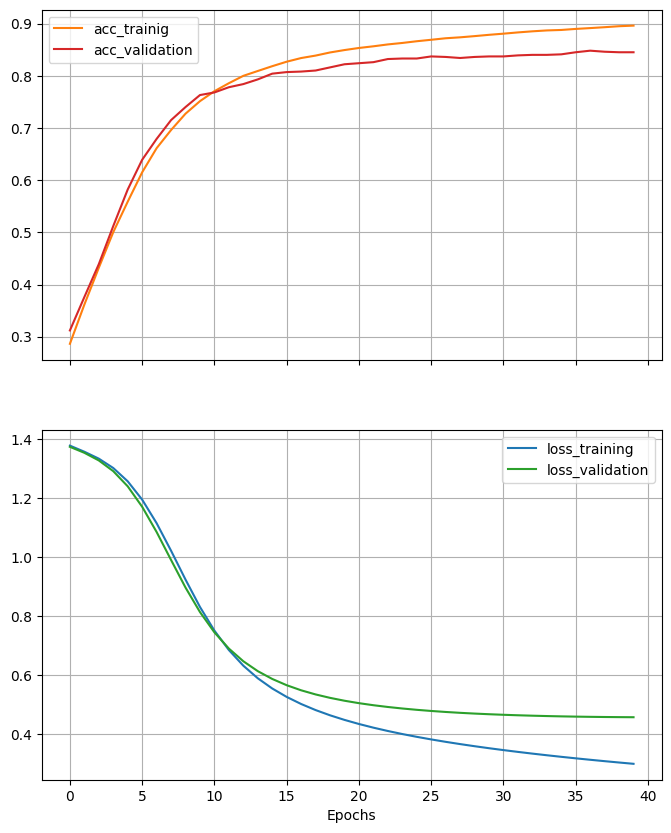

In [19]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):
    info = {'loss_training':loss_tr,'acc_trainig':acc_tr, 'loss_validation':loss_val, 'acc_validation':acc_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(8, 10), subplots=[('acc_trainig', 'acc_validation'), ('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

### [TO COMPLETE] Evaluate the model:

Now, our model has been optimized on the training set, and as you can see the performance on the validation set in quite similar (so it does not overfit the training data). Let's now evaluate the performance of our model using the test set. By having a look at the previous code, compute the performances on the test set.

`%STARTCODE`

In [20]:
model.eval()
total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0

#[TO COMPLETE]

loss_test = 0
with torch.no_grad():
    model.eval()
    for idx, (label, text) in enumerate(dataloader_test):
        logits = model(text)
        loss = criterion(logits, label)
        loss_test += loss
        total_acc_test += (logits.argmax(1) == label).sum().item()
        total_count_test += label.size(0)
        n_batches_test += 1

loss_test /= n_batches_test

accuracy_test = total_acc_test / total_count_test

print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
print(f"Test Accuracy: {100*accuracy_test:.4f}%")

Test Loss: 0.44434321 ---------- Test Accuracy: 84.3000%


`%ENDCODE`

Explain why it is important to use test and validation, and why it is important to evaluate the model on the test set instead of the validation set. Finally, explain what is the usefulness of the validation set. Insert the discussion in the next cell.



`%STARTEXT`

Answer: It is important to use test and validation sets in order to avoid overfitting and separate the data from the training set to increase the generalization capability of the model. The data from the test set is independent from the training and validation sets such that the unseen data can't be generalized by our model and will provide a better estimation of how well our model will perform. The validation set it's used to evaluate the performance of the model for different combinations of hyperparameter values, while the test set allows us to compare different models in an unbiased way and select the best one with the most proper combination of hyperparameters. Validation set is useful to tune the model hyperparameters, in order to improve the performance of the model on unseen data.

`%ENDTEXT`

# Exercise 2.2: Overfiting

A common problem that occurs when you train a deep neural network is overfittig. Overfitting occurs when you achieve a good fit of your model on the training data, while it does not generalize well on new, unseen data. In other words, the model learned patterns specific to the training data, which are irrelevant in other data.
As we have seen in the previous exercise, our model does not much overfit the training data. In this exercise, we try to modify the training parameters in order to have a model that overfits.
Overfitting can have many causes and usually is a combination of some of them, for instance: too many parameters/ layers, too few training samples, wrong learning rate (usualy too high), etc..


## [TO COMPLETE] Overfitting Model
In the next cell define a new model (similar to the previuos one) that overfits the training data; then plot the trend of the loss in training and validation set.



`%STARTCODE`

In [21]:
EPOCHS = 50#[TO COMPLETE]
lr = 1e-2#[TO COMPLETE]
overfit_model = overfit_model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[64, 128, 256, 512]).to(device)#[TO COMPLETE]
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
summary(overfit_model)

Layer (type:depth-idx)                   Param #
FeedforwardNetwork                       --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       64,064
│    └─Linear: 2-2                       8,320
│    └─Linear: 2-3                       33,024
│    └─Linear: 2-4                       131,584
│    └─Linear: 2-5                       2,052
Total params: 239,044
Trainable params: 239,044
Non-trainable params: 0

In [22]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(overfit_model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 66.28%, Loss: 0.86716765 ---------------- Val_Acc: 79.90%, Val_Loss: 0.55368674
epoch: 2 -> Accuracy: 86.77%, Loss: 0.37610120 ---------------- Val_Acc: 82.50%, Val_Loss: 0.55157912
epoch: 3 -> Accuracy: 91.07%, Loss: 0.26282549 ---------------- Val_Acc: 80.70%, Val_Loss: 0.66547376
epoch: 4 -> Accuracy: 92.59%, Loss: 0.21259677 ---------------- Val_Acc: 79.80%, Val_Loss: 0.69658834
epoch: 5 -> Accuracy: 93.45%, Loss: 0.19798934 ---------------- Val_Acc: 79.60%, Val_Loss: 0.83723640
epoch: 6 -> Accuracy: 95.30%, Loss: 0.14284448 ---------------- Val_Acc: 81.50%, Val_Loss: 0.80170053
epoch: 7 -> Accuracy: 96.70%, Loss: 0.10142764 ---------------- Val_Acc: 79.20%, Val_Loss: 0.93859702
epoch: 8 -> Accuracy: 97.75%, Loss: 0.06830747 ---------------- Val_Acc: 80.90%, Val_Loss: 1.03284359
epoch: 9 -> Accuracy: 98.84%, Loss: 0.03521222 ---------------- Val_Acc: 80.50%, Val_Loss: 1.22134590
epoch: 10 -> Accuracy: 99.02%, Loss: 0.03261640 ---------------- Val_Acc: 80.20%, 

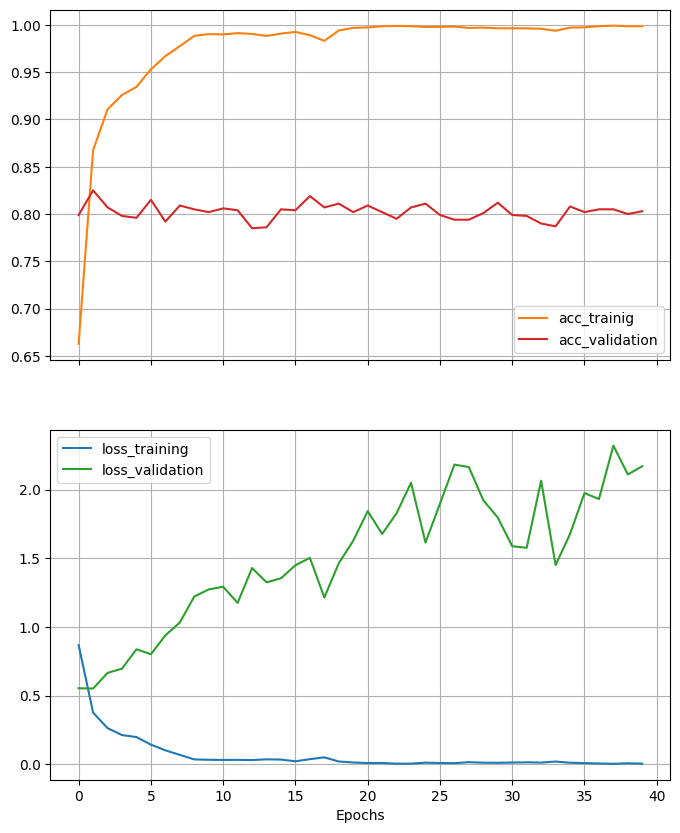

In [23]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

`%ENDCODE`

# Exercise 2.3: $L^1$- and $L^2$-regularization
One possible way to solve the overitting issue is by using regularization methods. The two most common regularization methods in Deep Learning are the L1-norm regularization and the L2-norm regularization. Both These techniques are based on limiting the capacity of models, by adding a parameter norm penalty to the objective function $\mathcal{J}$:
$$
\hat{\mathcal{J}}(\theta,\mathbf{X},\mathbf{y}) = \mathcal{J}(\theta,\mathbf{X},\mathbf{y}) + \lambda L^p(\theta)
$$
where $\lambda$ is a hyperparameter that weighs the relative contribution of the norm penalty $L^p$ on a lernable parameter vector $\theta$:
$$
 L^p(\theta)=||\theta||_p=\left(\sum_i |\theta_i|^p\right)^{1/p}
$$

In the following blocks you should implement both the $L^1$ and $L^2$ regularization for the overfitting model.

**Disclaimer**: you can implement norms either from scratch (i.e. using simple math operators) or using `torch.linalg` methods, but **not** using implementations embedded in Torch optimizers. 

### [TO COMPLETE] $L^1$ Regularization

`%STARTCODE`

In [24]:
def train_L1(model, optimizer, dataloader_train, dataloader_val, l1_lambda=1e-3, EPOCHS=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      ##########################################################
      #[TO COMPLETE]
      l1_norm = torch.linalg.norm(torch.cat([x.view(-1) for x in model.parameters()]), ord=1)
      loss_with_l1 = loss + l1_lambda * l1_norm
      ##########################################################
      total_loss_train += loss
      loss_with_l1.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [25]:
EPOCHS = 40
lr = 1e-4
overfit_model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[256, 128, 64]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
summary(overfit_model)

Layer (type:depth-idx)                   Param #
FeedforwardNetwork                       --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       256,256
│    └─Linear: 2-2                       32,896
│    └─Linear: 2-3                       8,256
│    └─Linear: 2-4                       260
Total params: 297,668
Trainable params: 297,668
Non-trainable params: 0

In [26]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_L1(overfit_model, optimizer, dataloader_training, dataloader_validation, l1_lambda=0.001)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 27.01%, Loss: 1.40457690 ---------------- Val_Acc: 32.00%, Val_Loss: 1.37370646
epoch: 2 -> Accuracy: 32.20%, Loss: 1.36461389 ---------------- Val_Acc: 35.10%, Val_Loss: 1.35386217
epoch: 3 -> Accuracy: 36.97%, Loss: 1.34432054 ---------------- Val_Acc: 38.20%, Val_Loss: 1.33446920
epoch: 4 -> Accuracy: 41.97%, Loss: 1.32201385 ---------------- Val_Acc: 42.60%, Val_Loss: 1.31068099
epoch: 5 -> Accuracy: 47.02%, Loss: 1.29381955 ---------------- Val_Acc: 47.10%, Val_Loss: 1.27937162
epoch: 6 -> Accuracy: 51.24%, Loss: 1.25701654 ---------------- Val_Acc: 51.00%, Val_Loss: 1.23803937
epoch: 7 -> Accuracy: 54.97%, Loss: 1.20939803 ---------------- Val_Acc: 57.50%, Val_Loss: 1.18533039
epoch: 8 -> Accuracy: 58.29%, Loss: 1.14998889 ---------------- Val_Acc: 61.40%, Val_Loss: 1.12166822
epoch: 9 -> Accuracy: 61.59%, Loss: 1.08067775 ---------------- Val_Acc: 64.10%, Val_Loss: 1.05046141
epoch: 10 -> Accuracy: 64.34%, Loss: 1.00808072 ---------------- Val_Acc: 66.00%, 

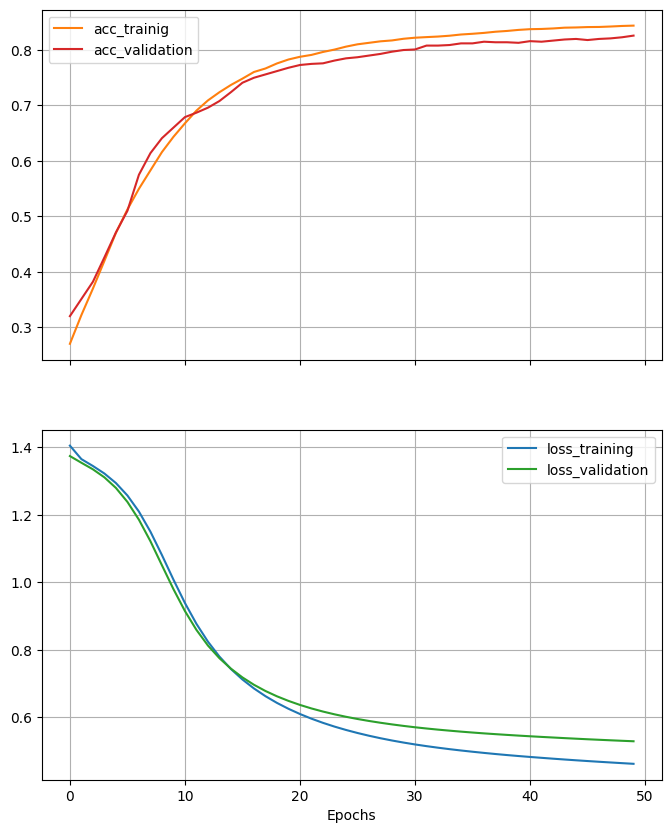

In [27]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

`%ENDCODE`

### [TO COMPLETE] $L^2$ Regularization



`%STARTCODE`

In [28]:
def train_L2(model, optimizer, dataloader_train, dataloader_val, l2_lambda=1e-3, EPOCHS=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      ##########################################################
      #[TO COMPLETE]
      l2_norm = torch.linalg.norm(torch.cat([x.view(-1) for x in model.parameters()]), ord=2)
      loss_with_l2 = loss + l2_lambda * l2_norm
      ##########################################################
      total_loss_train += loss
      loss_with_l2.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [29]:
EPOCHS = 40
lr = 1e-4
overfit_model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[256, 128, 64]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
summary(overfit_model)

Layer (type:depth-idx)                   Param #
FeedforwardNetwork                       --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       256,256
│    └─Linear: 2-2                       32,896
│    └─Linear: 2-3                       8,256
│    └─Linear: 2-4                       260
Total params: 297,668
Trainable params: 297,668
Non-trainable params: 0

In [30]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_L2(overfit_model, optimizer, dataloader_training, dataloader_validation, l2_lambda=0.01)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 34.26%, Loss: 1.35748518 ---------------- Val_Acc: 41.50%, Val_Loss: 1.32538664
epoch: 2 -> Accuracy: 49.12%, Loss: 1.28207684 ---------------- Val_Acc: 52.20%, Val_Loss: 1.24036252
epoch: 3 -> Accuracy: 60.43%, Loss: 1.16911125 ---------------- Val_Acc: 63.00%, Val_Loss: 1.10628915
epoch: 4 -> Accuracy: 68.65%, Loss: 1.00889802 ---------------- Val_Acc: 68.40%, Val_Loss: 0.93935019
epoch: 5 -> Accuracy: 73.54%, Loss: 0.83826172 ---------------- Val_Acc: 72.90%, Val_Loss: 0.79054022
epoch: 6 -> Accuracy: 76.94%, Loss: 0.70168281 ---------------- Val_Acc: 75.70%, Val_Loss: 0.68848205
epoch: 7 -> Accuracy: 79.60%, Loss: 0.60789484 ---------------- Val_Acc: 77.40%, Val_Loss: 0.62384945
epoch: 8 -> Accuracy: 81.40%, Loss: 0.54292107 ---------------- Val_Acc: 78.80%, Val_Loss: 0.58088046
epoch: 9 -> Accuracy: 82.87%, Loss: 0.49486762 ---------------- Val_Acc: 80.30%, Val_Loss: 0.55127883
epoch: 10 -> Accuracy: 84.11%, Loss: 0.45705819 ---------------- Val_Acc: 80.80%, 

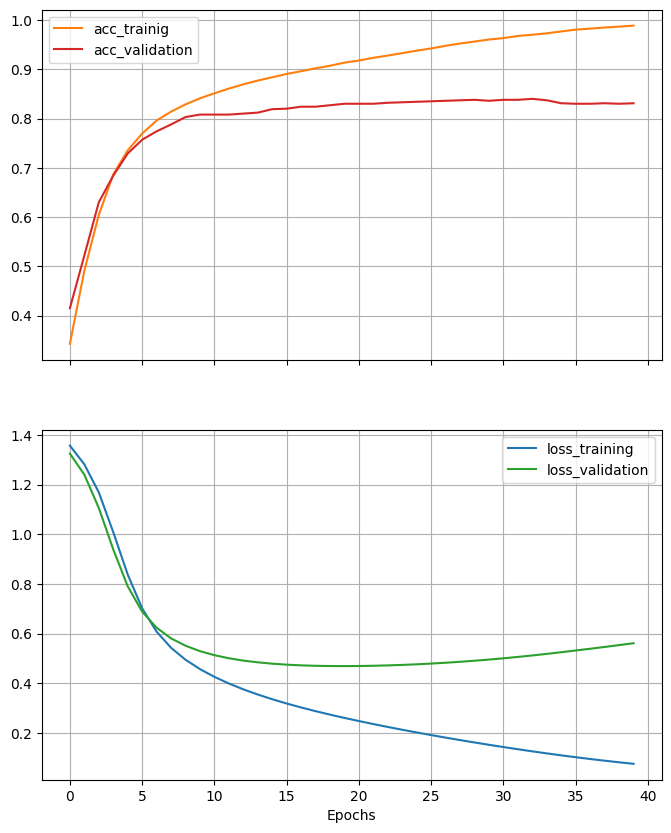

In [31]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

`%ENDCODE`

# Exercise 2.4: Early Stopping
Early Stopping is a form of regularization used to avoid overfitting. It is designed to monitor the generalization error of one model and stop training when generalization error begins to degrade. In order to evaluate the generalization error, early stopping requires that a validation dataset is evaluated during training. Then, when the validation error does not improve for a specific number of epochs (a.k.a. the "patience" or "tolerance" hyper-parameter), it stops the training phase.

To implement it in PyTorch, we define a simple classes that does this job.

In [32]:
class EarlyStopping:
    def __init__(self, tolerance, min_delta):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

## **[TO COMPLETE]**: Define training procedure
Define a training procedure with Early Stopping and check its performances.



`%STARTCODE`

In [33]:
def train_early_stop(model, optimizer, dataloader_train, dataloader_val, EPOCHS=EPOCHS):
  ###########################################################
  # instantiate an object of the EarlyStopping class 
  early_stopping = EarlyStopping(10, 0.1)
  ###########################################################
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
    ############################################################
    # Use the EarlyStopping object
    early_stopping(avg_loss_train, avg_loss_val)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    ############################################################
  return loss_train, acc_train, loss_val, acc_val

In [34]:
EPOCHS = 40
lr = 1e-4
overfit_model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[256, 128, 64]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
summary(overfit_model)

Layer (type:depth-idx)                   Param #
FeedforwardNetwork                       --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       256,256
│    └─Linear: 2-2                       32,896
│    └─Linear: 2-3                       8,256
│    └─Linear: 2-4                       260
Total params: 297,668
Trainable params: 297,668
Non-trainable params: 0

In [35]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_early_stop(overfit_model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 28.36%, Loss: 1.38196051 ---------------- Val_Acc: 35.40%, Val_Loss: 1.34951663
epoch: 2 -> Accuracy: 43.80%, Loss: 1.31581056 ---------------- Val_Acc: 49.50%, Val_Loss: 1.28442812
epoch: 3 -> Accuracy: 56.30%, Loss: 1.22867155 ---------------- Val_Acc: 60.20%, Val_Loss: 1.18003523
epoch: 4 -> Accuracy: 65.85%, Loss: 1.09263325 ---------------- Val_Acc: 67.30%, Val_Loss: 1.02855992
epoch: 5 -> Accuracy: 72.12%, Loss: 0.91894561 ---------------- Val_Acc: 71.90%, Val_Loss: 0.86386609
epoch: 6 -> Accuracy: 76.26%, Loss: 0.75575757 ---------------- Val_Acc: 75.00%, Val_Loss: 0.73429096
epoch: 7 -> Accuracy: 79.21%, Loss: 0.63690108 ---------------- Val_Acc: 77.90%, Val_Loss: 0.65080738
epoch: 8 -> Accuracy: 81.44%, Loss: 0.55735081 ---------------- Val_Acc: 79.20%, Val_Loss: 0.59973335
epoch: 9 -> Accuracy: 83.00%, Loss: 0.50260288 ---------------- Val_Acc: 79.90%, Val_Loss: 0.56737101
epoch: 10 -> Accuracy: 84.11%, Loss: 0.46187407 ---------------- Val_Acc: 80.90%, 

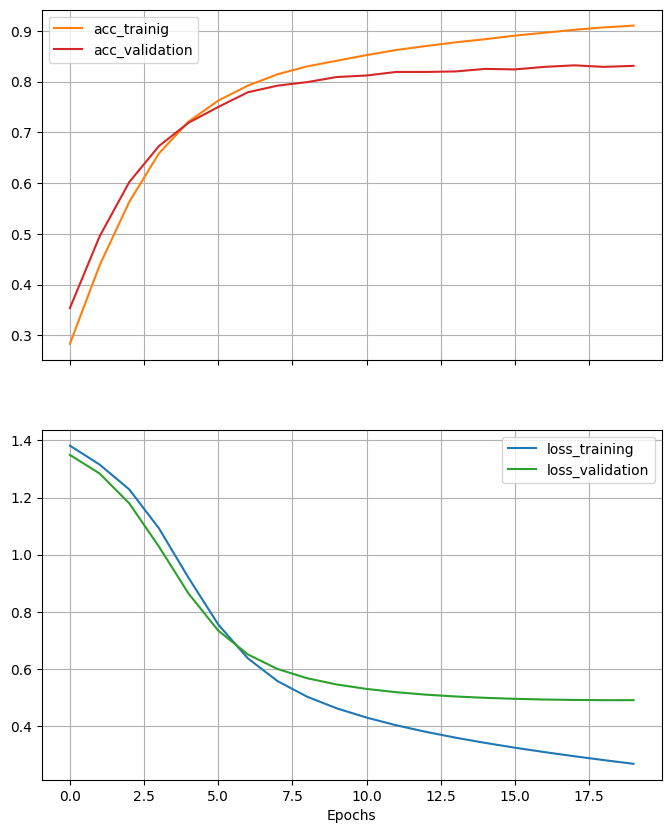

In [36]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

`%ENDCODE`

# Model Selection
Hyperparameters are the parameters of the learning method itself which we have to specify a priori, i.e., before model fitting. In contrast, model parameters are parameters which arise as a result of the fit (the network weights). The aim of model selection is selecting the best hyperparameters for our deep network. Finding the right hyperparameters for a model can be crucial for the model performance on given data. For istance lets consider our model trained by using different values for the learning rate: 

In [37]:
learning_rates = [1e-5, 1e-4, 1e-3]

In [38]:
stack = []
for lr in learning_rates:
  print(f"Learning Rate: {lr}")
  model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[128, 64]).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  stack.append(train(model, optimizer, dataloader_training, dataloader_validation, EPOCHS=15))
  print("-"*50)

Learning Rate: 1e-05
epoch: 1 -> Accuracy: 28.07%, Loss: 1.38209856 ---------------- Val_Acc: 28.60%, Val_Loss: 1.38077569
epoch: 2 -> Accuracy: 28.90%, Loss: 1.37768924 ---------------- Val_Acc: 29.40%, Val_Loss: 1.37688899
epoch: 3 -> Accuracy: 30.03%, Loss: 1.37353182 ---------------- Val_Acc: 31.10%, Val_Loss: 1.37309313
epoch: 4 -> Accuracy: 30.81%, Loss: 1.36945724 ---------------- Val_Acc: 32.10%, Val_Loss: 1.36934543
epoch: 5 -> Accuracy: 31.74%, Loss: 1.36543167 ---------------- Val_Acc: 33.00%, Val_Loss: 1.36560988
epoch: 6 -> Accuracy: 32.93%, Loss: 1.36142588 ---------------- Val_Acc: 34.10%, Val_Loss: 1.36188805
epoch: 7 -> Accuracy: 34.09%, Loss: 1.35742021 ---------------- Val_Acc: 35.30%, Val_Loss: 1.35814977
epoch: 8 -> Accuracy: 35.17%, Loss: 1.35338974 ---------------- Val_Acc: 36.30%, Val_Loss: 1.35438025
epoch: 9 -> Accuracy: 36.26%, Loss: 1.34933043 ---------------- Val_Acc: 37.70%, Val_Loss: 1.35058105
epoch: 10 -> Accuracy: 37.47%, Loss: 1.34523189 -------------

Learning Rate: 1e-05


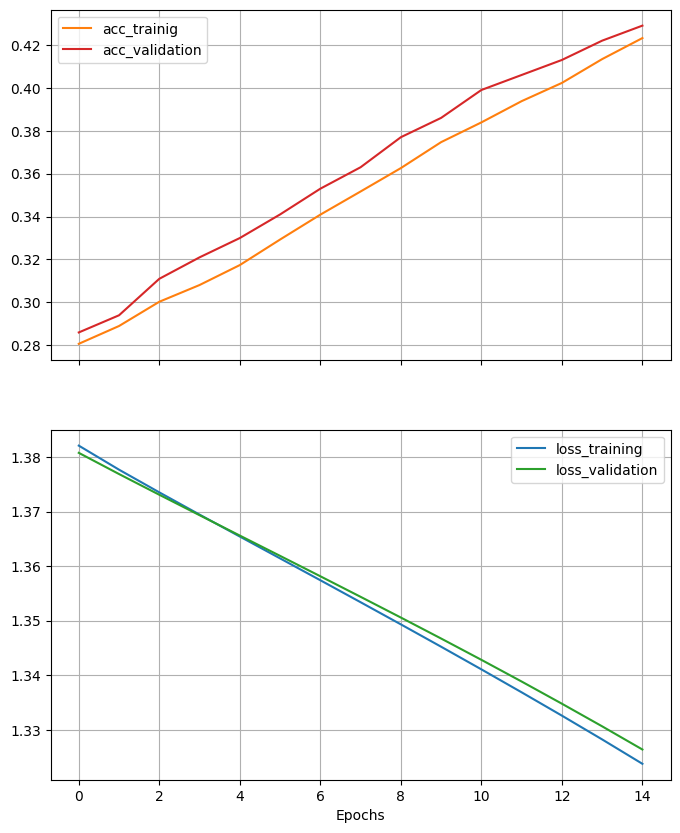

Learning Rate: 0.0001


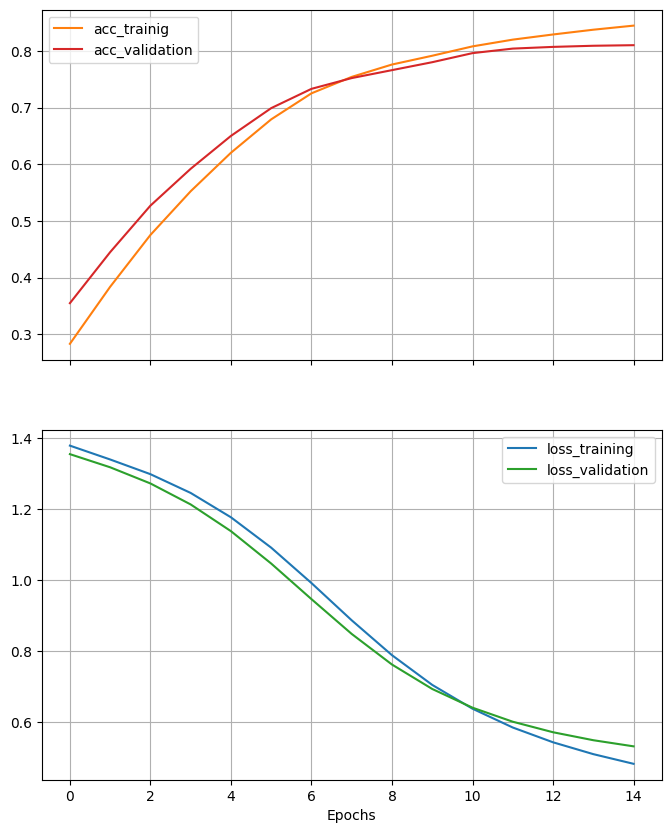

Learning Rate: 0.001


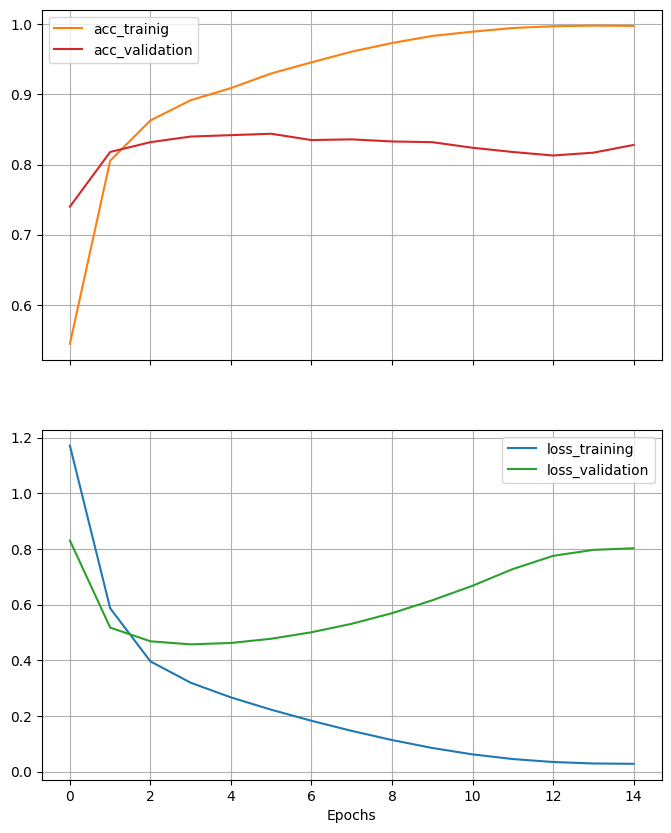

In [39]:
# Let's plot the results
for idx, el in enumerate(stack):
  print(f"Learning Rate: {learning_rates[idx]}")
  plot_learning_acc_and_loss(*el)

# Exercise 2.5: Grid Search

Since a deep net has many hyperparameters, in order to find the best ones, we have to consider different possible combinations of values for each hyper-parameter. One common method to perform this complex task is Grid-Search.
Given a set of values for each hyper-parameter, Grid-Search will build a model on each parameter combination possible. It iterates through every parameter combination and stores a model for each combination. Finally, the model that obtained the best result on the validation set will be selected.

In order to perfrom Grid-Search we will use the `GridSearchCV` class from `scikit-learn`, together with some classes from the `skorch` package which allows to use PyTorch models with `scikit-learn`.

In [40]:
model = NeuralNetClassifier(
    module=FeedforwardNetwork,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    max_epochs=2)

# we need to adapt PyTorch Dataset to work with Scikit-Learn GridSearchCV
# we use the SliceDataset class from skorch package for this purpose
X_slice = SliceDataset(train_dataset, idx=1)
y_slice = SliceDataset(train_dataset, idx=0)

## **[TO COMPLETE]**: Define hyperparameters grid

Let's define the lists of hyper-parameters' values. Also in this case, we use dictionaries of very limited size and hyperparameters, but in a real-world scenario a reasonable amount of possible values should be considered (and there are many other approacehs besisdes Grid-Search).

`%STARTCODE`

In [41]:
params = {
    'lr': [1e-4, 1e-3, 1e-2],
    'module__input_dim': [1000],
    'module__num_classes': [4],
    'module__hidden_layers_dim': [[256, 128, 64, 32]], 
    }

`%ENDCODE`

Now you can use `sklearn`'s `GridSearchCV` to search the hyperparameter space of the `NeuralNetClassifier`:

In [42]:
n_jobs = multiprocessing.cpu_count()-1
gs = GridSearchCV(model, params, n_jobs=n_jobs)

In [43]:
outputs = gs.fit(X_slice, y_slice)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3794       0.3525        1.3693  8.6475
      2        1.3557       0.4444        1.3404  8.5739
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3812       0.3294        1.3743  7.8051
      2        1.3597       0.4113        1.3487  8.0631
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3820       0.3556        1.3654  8.5979
      2        1.3378       0.4725        1.3147  8.6155
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3768       0.3781        1.3695  7.5696
      2        1.3481       0.5025        1.3349  8.3221
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  --------

## **[TO COMPLETE]**: Visualize results
Print the best hyper-parameters and the performances on the best model on the test set:



`%STARTCODE`

In [44]:
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_)) #[TO COMPLETE]

best score: 0.815, best params: {'lr': 0.001, 'module__hidden_layers_dim': [256, 128, 64, 32], 'module__input_dim': 1000, 'module__num_classes': 4}


In [45]:
# Test the model
best_model = gs.best_estimator_
test_score = gs.score(X_slice, y_slice)
print("Test accuracy score: {:.3f}".format(test_score))


Test accuracy score: 0.889


`%ENDCODE`